In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

### Slightly modified method from the first exercise

In [9]:
def extract_egonet_features(G):
    features = {
        'N': {},  # number of neighbors
        'E': {},  # number of edges in egonet
        'W': {},  # total weight in egonet (will be same as E for unweighted graphs)
        'lambda': {}  # principal eigenvalue
    }
    
    for node in G.nodes():
        neighbors = set(G.neighbors(node))
        neighbors.add(node)
        egonet = G.subgraph(neighbors)
        
        features['N'][node] = len(neighbors) - 1  
        features['E'][node] = egonet.number_of_edges()
        features['W'][node] = features['E'][node]
        
        adj_matrix = nx.to_numpy_array(egonet)
        
        try:
            eigenvals = np.linalg.eigvals(adj_matrix)
            principal_eigenval = max(abs(eigenvals))
            features['lambda'][node] = float(principal_eigenval.real)
        except:
            features['lambda'][node] = 0.0
    
    nx.set_node_attributes(G, features['N'], 'N')
    nx.set_node_attributes(G, features['E'], 'E')
    nx.set_node_attributes(G, features['W'], 'W')
    nx.set_node_attributes(G, features['lambda'], 'lambda')
    
    return G

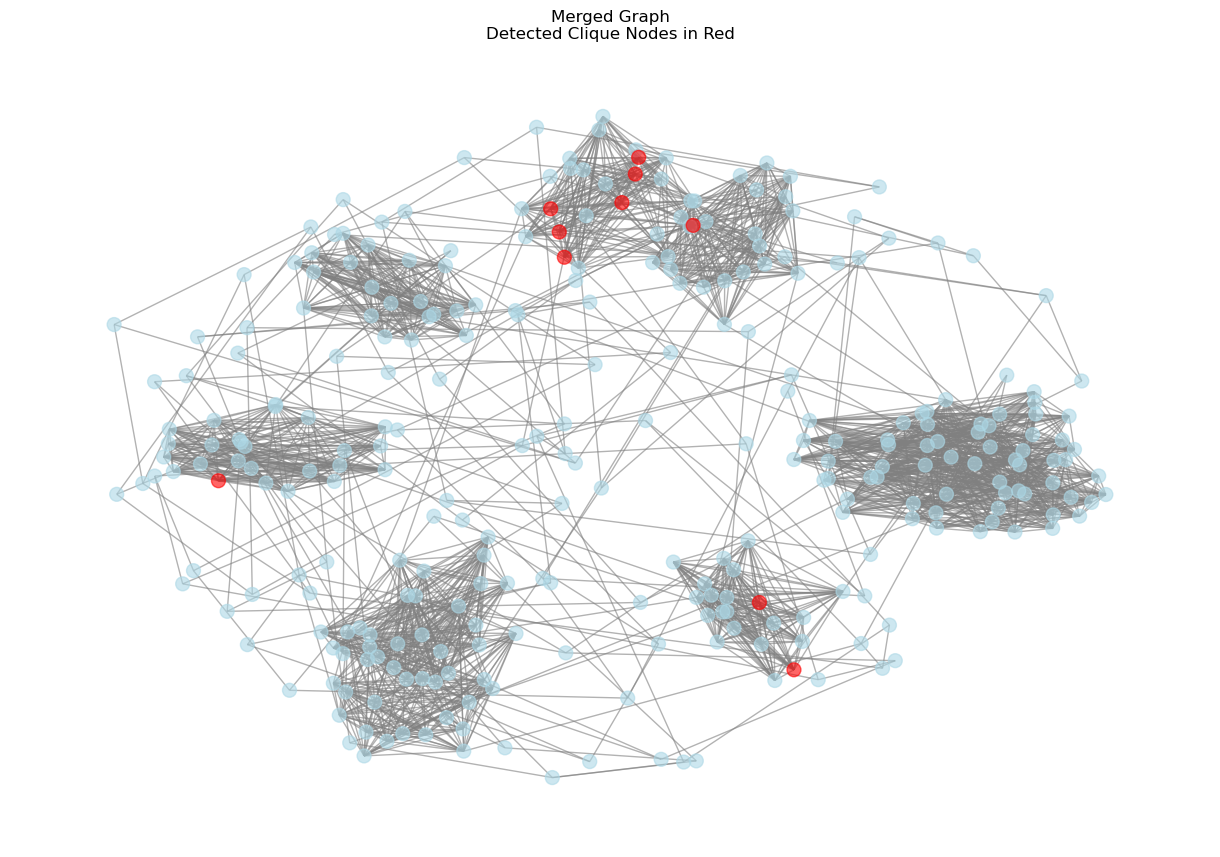


Highlighted nodes (likely clique members):
Node C-27: E=189, N=19
Node C-91: E=189, N=19
Node C-92: E=189, N=19
Node C-26: E=189, N=19
Node C-94: E=189, N=19
Node C-95: E=189, N=19
Node C-96: E=189, N=19
Node C-97: E=189, N=19
Node C-90: E=189, N=19
Node C-49: E=189, N=19

Graph Statistics:
Total nodes: 300
Total edges: 2070


In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def generate_merged_graph():
    regular_graph = nx.random_regular_graph(d=3, n=100)
    
    caveman_graph = nx.connected_caveman_graph(l=10, k=20)
    
    merged_graph = nx.union(regular_graph, caveman_graph, 
                          rename=('R-', 'C-'))  
    
    regular_nodes = [f"R-{i}" for i in range(100)]
    caveman_nodes = [f"C-{i}" for i in range(200)]  
    
    for _ in range(20):
        node1 = np.random.choice(regular_nodes)
        node2 = np.random.choice(caveman_nodes)
        merged_graph.add_edge(node1, node2)
    
    return merged_graph

def detect_clique_nodes(G):
    G = extract_egonet_features(G)
    
    nodes = list(G.nodes())
    E_values = np.array([G.nodes[node]['E'] for node in nodes])
    N_values = np.array([G.nodes[node]['N'] for node in nodes])
    
    ratios = E_values / (N_values + 1)  
    
    top_10_indices = np.argsort(ratios)[-10:]
    top_10_nodes = [nodes[i] for i in top_10_indices]
    
    return top_10_nodes

def draw_merged_graph(G, highlighted_nodes):
    plt.figure(figsize=(12, 8))
    
    color_map = ['red' if node in highlighted_nodes else 'lightblue' 
                 for node in G.nodes()]
    
    # Draw the graph
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos,
            node_color=color_map,
            node_size=100,
            with_labels=False,
            alpha=0.6,
            edge_color='gray')
    
    plt.title("Merged Graph\nDetected Clique Nodes in Red")
    plt.show()
    
    print("\nHighlighted nodes (likely clique members):")
    for node in highlighted_nodes:
        print(f"Node {node}: E={G.nodes[node]['E']}, N={G.nodes[node]['N']}")

G = generate_merged_graph()

clique_nodes = detect_clique_nodes(G)

draw_merged_graph(G, clique_nodes)

print("\nGraph Statistics:")
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

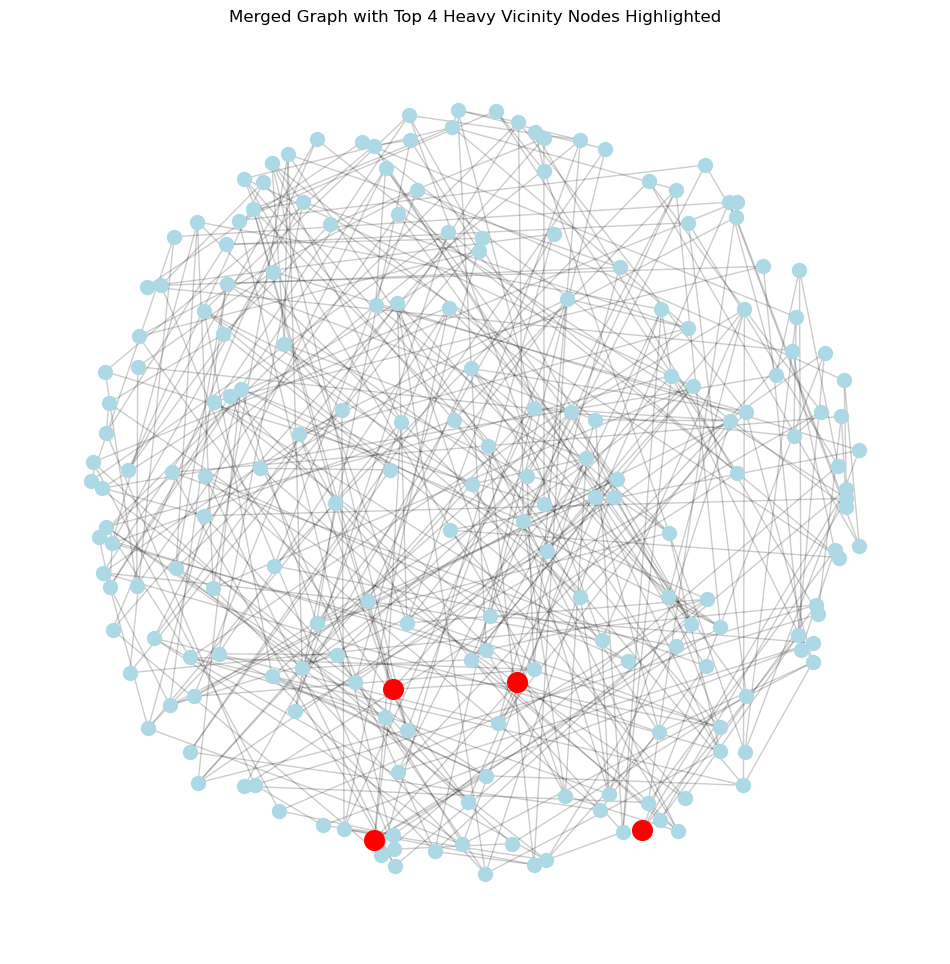


Top 4 nodes with heaviest vicinities:
Node B-16: Score = 5.500
Node B-4: Score = 5.000
Node B-64: Score = 2.500
Node A-94: Score = 1.000


In [2]:
regular_graph_3 = nx.random_regular_graph(d=3, n=100)
regular_graph_5 = nx.random_regular_graph(d=5, n=100)

merged_graph = nx.union(regular_graph_3, regular_graph_5, rename=('A-', 'B-'))

for edge in merged_graph.edges():
    merged_graph.add_edge(edge[0], edge[1], weight=1)

nodes = list(merged_graph.nodes())
random_nodes = np.random.choice(nodes, 2, replace=False)

for node in random_nodes:
    egonet = nx.ego_graph(merged_graph, node)
    for edge in egonet.edges():
        merged_graph[edge[0]][edge[1]]["weight"] += 10

node_metrics = {}
for node in merged_graph.nodes():
    neighbors = set(merged_graph.neighbors(node))
    if len(neighbors) == 0:
        continue
        
    possible_edges = len(neighbors) * (len(neighbors) - 1) / 2
    actual_edges = sum(1 for n1 in neighbors for n2 in neighbors if n1 < n2 and merged_graph.has_edge(n1, n2))
    Ei = actual_edges / possible_edges if possible_edges > 0 else 0
    
    Wi = sum(merged_graph[node][neighbor]["weight"] for neighbor in neighbors)
    
    score = Ei * Wi
    node_metrics[node] = score

top_4_nodes = sorted(node_metrics.items(), key=lambda x: x[1], reverse=True)[:4]
top_4_node_ids = [node for node, _ in top_4_nodes]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(merged_graph, k=1, iterations=50)

nx.draw_networkx_nodes(merged_graph, 
                      pos, 
                      nodelist=[n for n in merged_graph.nodes() if n not in top_4_node_ids],
                      node_color='lightblue',
                      node_size=100)

nx.draw_networkx_nodes(merged_graph,
                      pos,
                      nodelist=top_4_node_ids,
                      node_color='red',
                      node_size=200)

nx.draw_networkx_edges(merged_graph, pos, alpha=0.2)

plt.title("Merged Graph with Top 4 Heavy Vicinity Nodes Highlighted")
plt.axis('off')
plt.show()

print("\nTop 4 nodes with heaviest vicinities:")
for node, score in top_4_nodes:
    print(f"Node {node}: Score = {score:.3f}")